In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Reading in the data
df = pd.read_excel("/content/MilkDataset.xlsx", index_col = "Date", parse_dates = True)
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


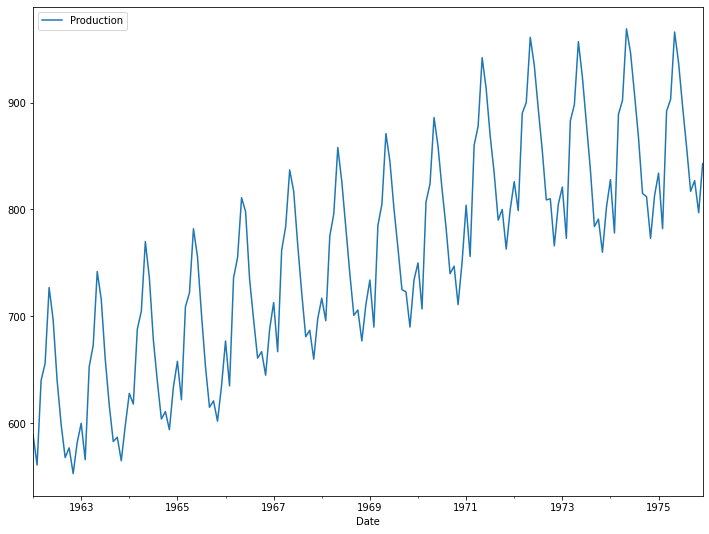

In [3]:
# Plotting the dataset
df.plot(figsize = (12, 9))

In [4]:
# Infering the seasonality of the data
from statsmodels.tsa.seasonal import seasonal_decompose

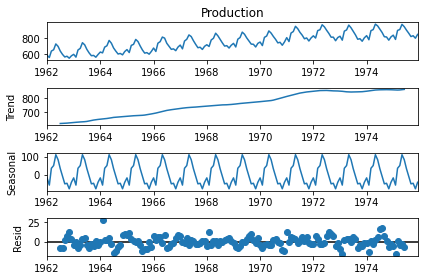

In [5]:
results = seasonal_decompose(df["Production"])
results.plot();

# Now we check the length of the dataset and use the last 12 months as the test dataset, and everyting before that as the training dataset

In [6]:
len(df)

168

## 168 - 12 (last 12 months) = 156

In [7]:
train_data = df.iloc[:156] # All rows starting from index 0 to index 156 
test_data = df.iloc[156:] # all rows starting from index 156 to the last index

# Scaling the data

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_training_data = scaler.fit_transform(train_data) 
scaled_testing_data = scaler.fit_transform(test_data)

# Formatting the data to feed to LSTM model - Batching the data

In [9]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [10]:
# defining the generator -- I feed it batches of 3 months (3 months data at a time) and then I wnat to it predict the
                         # next month (4th month)

n_input = 12 # I feed it a batch of twelve
n_features = 1 # I want it to predict only the next value, it would be more if you are using multiple time series
generator = TimeseriesGenerator(scaled_training_data, scaled_training_data, length = n_input, batch_size = 1)

# Building the model

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [12]:
# Defining the model
model = Sequential() # Layers are in a sequence one after the other
model.add(LSTM(100, activation = "relu", input_shape = (n_input, n_features))) # LSTM model with 100 neurons, activation function is ReLU,
                                                                               # and  
model.add(Dense(1)) # The output layer
model.compile(optimizer = "adam", loss = "mse") # Compiling the model

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Fitting the model
model.fit(generator, epochs = 100)

Epoch 1/100
144/144 [==============================] - 7s 36ms/step - loss: 0.0488
Epoch 2/100
144/144 [==============================] - 6s 45ms/step - loss: 0.0214
Epoch 3/100
144/144 [==============================] - 6s 39ms/step - loss: 0.0215
Epoch 4/100
144/144 [==============================] - 3s 20ms/step - loss: 0.0134
Epoch 5/100
144/144 [==============================] - 3s 21ms/step - loss: 0.0082
Epoch 6/100
144/144 [==============================] - 3s 21ms/step - loss: 0.0060
Epoch 7/100
144/144 [==============================] - 3s 21ms/step - loss: 0.0048
Epoch 8/100
144/144 [==============================] - 4s 26ms/step - loss: 0.0070
Epoch 9/100
144/144 [==============================] - 3s 20ms/step - loss: 0.0049
Epoch 10/100
144/144 [==============================] - 3s 21ms/step - loss: 0.0045
Epoch 11/100
144/144 [==============================] - 3s 20ms/step - loss: 0.0042
Epoch 12/100
144/144 [==============================] - 3s 20ms/step - loss: 0.0049
E

Text(0.5, 0, 'Epoch')

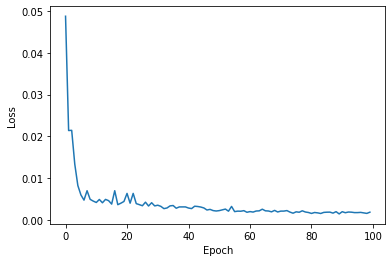

In [15]:
# Plotting the loss
loss_per_epoch = model.history.history["loss"]
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)
plt.ylabel("Loss")
plt.xlabel("Epoch")

# Making Predictions

In [16]:
from matplotlib import test
test_predictions = []

first_eval_batch = scaled_training_data[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):

  # Prediction value in the first batch
  current_prediction = model.predict(current_batch)[0]

  # Appending the prediction into the array
  test_predictions.append(current_prediction)

  # Using the prediction to update the batch and removing the current value
  current_batch = np.append(current_batch[:, 1:, :], [[current_prediction]], axis = 1)

1/1 [==============================] - 0s 19ms/step


# At this point, because you scaled your data, it will be in the range $\left(0, 1\right)$, we will have to transform it back to the original scale!

In [17]:
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions

array([[904.80473709],
       [895.36811638],
       [930.98107338],
       [938.00598383],
       [962.18831968],
       [955.77089643],
       [943.81435156],
       [926.33456564],
       [906.36080408],
       [900.13733673],
       [887.88477468],
       [898.08110809]])

In [18]:
# Appending the true preictions to the testing dataset

test_data["Predictions"] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


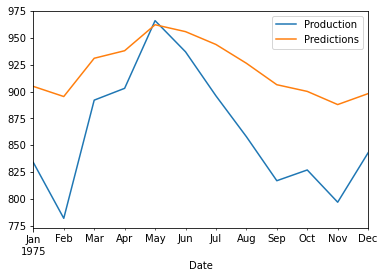

In [19]:
# Plotting the test dataset and the predicted values
test_data.plot()

# Calculating the error in prediction

In [20]:
from sklearn.metrics import mean_squared_error
import math

rmse = math.sqrt(mean_squared_error(test_data["Production"], test_data["Predictions"]))
rmse

66.18262498308499